<a href="https://colab.research.google.com/github/ypeng12/Airline/blob/main/AirlineGraph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

sort the time

get the csv and got the total time for the flight

In [3]:
import pandas as pd
import os
import re
from datetime import datetime

# Define the raw data
raw_data = """


HA	Hawaiian Airlines
HA204
	KE7754
	JL6609
	DL6841
	B65853
Honolulu, HIIn Air11:10 AM11:07 AM
AS	Alaska Airlines
AS840
Seattle, WAIn Air11:13 AM11:06 AM10
HA	Hawaiian Airlines
HA234
	UA7874
	JL6607
	DL6848
	B65848
Honolulu, HIScheduled11:45 AM
WN	Southwest Airlines
WN2355
Honolulu, HIScheduled11:50 AM11:50 AM7
HA	Hawaiian Airlines
HA66
Sacramento, CAScheduled12:00 PM
HA	Hawaiian Airlines
HA254
	UA7849
	JL6610
	DL6825
	B65880
	AA7873
Honolulu, HIScheduled12:25 PM
UA	United Airlines
UA1563
	LH8932
	AV2357
San Francisco, CAScheduled12:52 PM12:52 PM8
AS	Alaska Airlines
AS577
	AA9348
San Jose, CAScheduled12:59 PM12:59 PM10
HA	Hawaiian Airlines
HA264
	JL6612
	DL6851
	B65888
	AA7870
Honolulu, HIScheduled1:03 PM
HA	Hawaiian Airlines
HA68
Oakland, CAScheduled1:05 PM
UA	United Airlines
UA466
	AV2258
	AC3502
Los Angeles, CAScheduled1:09 PM1:09 PM9
HA	Hawaiian Airlines
HA64
Los Angeles, CAScheduled1:35 PM
AA	American Airlines
AA266
Los Angeles, CAScheduled1:42 PM1:42 PM6
HA	Hawaiian Airlines
HA274
	JL6613
	DL6852
Honolulu, HIScheduled1:59 PM
 """

# Split the data into lines
lines = raw_data.split('\n')
data = []

# Initialize variables for processing
airline = airline_code = flight = to = sched = updated = None
status_keywords = {"In", "Arrived", "Scheduled", "Delayed", "Landed", "No", "Departed","Cancelled"}

def is_flight_number(s, airline_code):
    return s.startswith(airline_code) and any(char.isdigit() for char in s)

def extract_to_and_status(parts):
    combined = ' '.join(parts)
    for keyword in status_keywords:
        if keyword in combined:
            to_part, status_part = combined.split(keyword, 1)
            return to_part.strip(), keyword, status_part.strip()
    return combined, "", ""

def extract_times(remaining):
    time_pattern = r'\d{1,2}:\d{2} [AP]M'
    times = re.findall(time_pattern, remaining)
    converted_times = [convert_time(t) for t in times]
    return converted_times

def convert_time(time_str):
    # Parse the time using datetime and convert to 24-hour format
    return datetime.strptime(time_str, '%I:%M %p').strftime('%H:%M')

for i, line in enumerate(lines):
    parts = line.split()

    if not parts:
        continue  # Skip empty lines

    if i+1 < len(lines) and parts and lines[i+1].split() and is_flight_number(lines[i+1].split()[0], parts[0]):
        airline = line
        airline_code = parts[0]
    elif airline_code and parts and is_flight_number(parts[0], airline_code):
        flight = parts[0]
    else:
        to, status, remaining = extract_to_and_status(parts)
        if ',' not in to:
            continue
        times = extract_times(remaining)
        sched = times[0] if times else ""
        updated = times[1] if len(times) > 1 else ""

        data.append([airline_code, flight, to, sched, updated])
        flight = to = sched = updated = None

# Define column names
columns = ['Airline', 'Flight', 'To', 'Sched.', 'Updated']

# Create a DataFrame
df = pd.DataFrame(data, columns=columns)

# Define the path to the Downloads directory
downloads_directory = os.path.expanduser('~/Hawaii')
os.makedirs(downloads_directory, exist_ok=True)

# Define the full path to the CSV file
csv_file = os.path.join(downloads_directory, 'Lihue_0705_2024.csv')
excel_file = os.path.join(downloads_directory, 'Lihue_0705_2024.xlsx')

# Save the DataFrame to a CSV file
df.to_csv(csv_file, index=False)
print(f"Data has been written to {csv_file}")

# Save the DataFrame to an Excel file
df.to_excel(excel_file, index=False)
print(f"Data has been written to {excel_file}")


Data has been written to /root/Hawaii/Lihue_0705_2024.csv
Data has been written to /root/Hawaii/Lihue_0705_2024.xlsx


In [18]:
import pandas as pd
import os

def group_flights_by_interval(file_path, interval_minutes):
    # Extract the name from the file path
    file_name = os.path.basename(file_path).split('_')[0]

    # Read the CSV file
    df = pd.read_csv(file_path)

    # Convert 'Sched.' to datetime and extract the time in minutes
    df['Sched.'] = pd.to_datetime(df['Sched.'], format='%H:%M', errors='coerce')
    df['Minutes'] = df['Sched.'].dt.hour * 60 + df['Sched.'].dt.minute

    # Calculate the interval bin for each flight
    df['Interval'] = (df['Minutes'] // interval_minutes) * interval_minutes

    # Create a column for the exact interval time
    df['Interval Time'] = pd.to_datetime(df['Interval'], unit='m').dt.strftime('%H:%M')

    # Group by the interval time and count the number of flights
    grouped_flights = df.groupby('Interval Time').size().reset_index(name=file_name)

    return grouped_flights

def process_all_files(directory_path, interval_minutes, output_file):
    all_data = None

    for file_name in os.listdir(directory_path):
        file_path = os.path.join(directory_path, file_name)
        if os.path.isfile(file_path):
            grouped_flights = group_flights_by_interval(file_path, interval_minutes)
            if all_data is None:
                all_data = grouped_flights
            else:
                all_data = pd.merge(all_data, grouped_flights, on='Interval Time', how='outer')

    # Fill NaN values with 0 and save the combined data to a CSV file
    all_data = all_data.fillna(0)
    all_data.to_csv(output_file, index=False)

# Example usage
directory_path = '/mnt/hawaii'  # Adjust this to your actual directory path
output_file = '/mnt/data/flight_status.csv'  # Adjust this to your desired output file path
interval_minutes = 30  # Set this to the desired interval in minutes

# Process all files and save the combined data
process_all_files(directory_path, interval_minutes, output_file)

print(f"Combined flight data saved to: {output_file}")


Combined flight data saved to: /mnt/data/flight_status.csv


got the file in data and could change by type the int


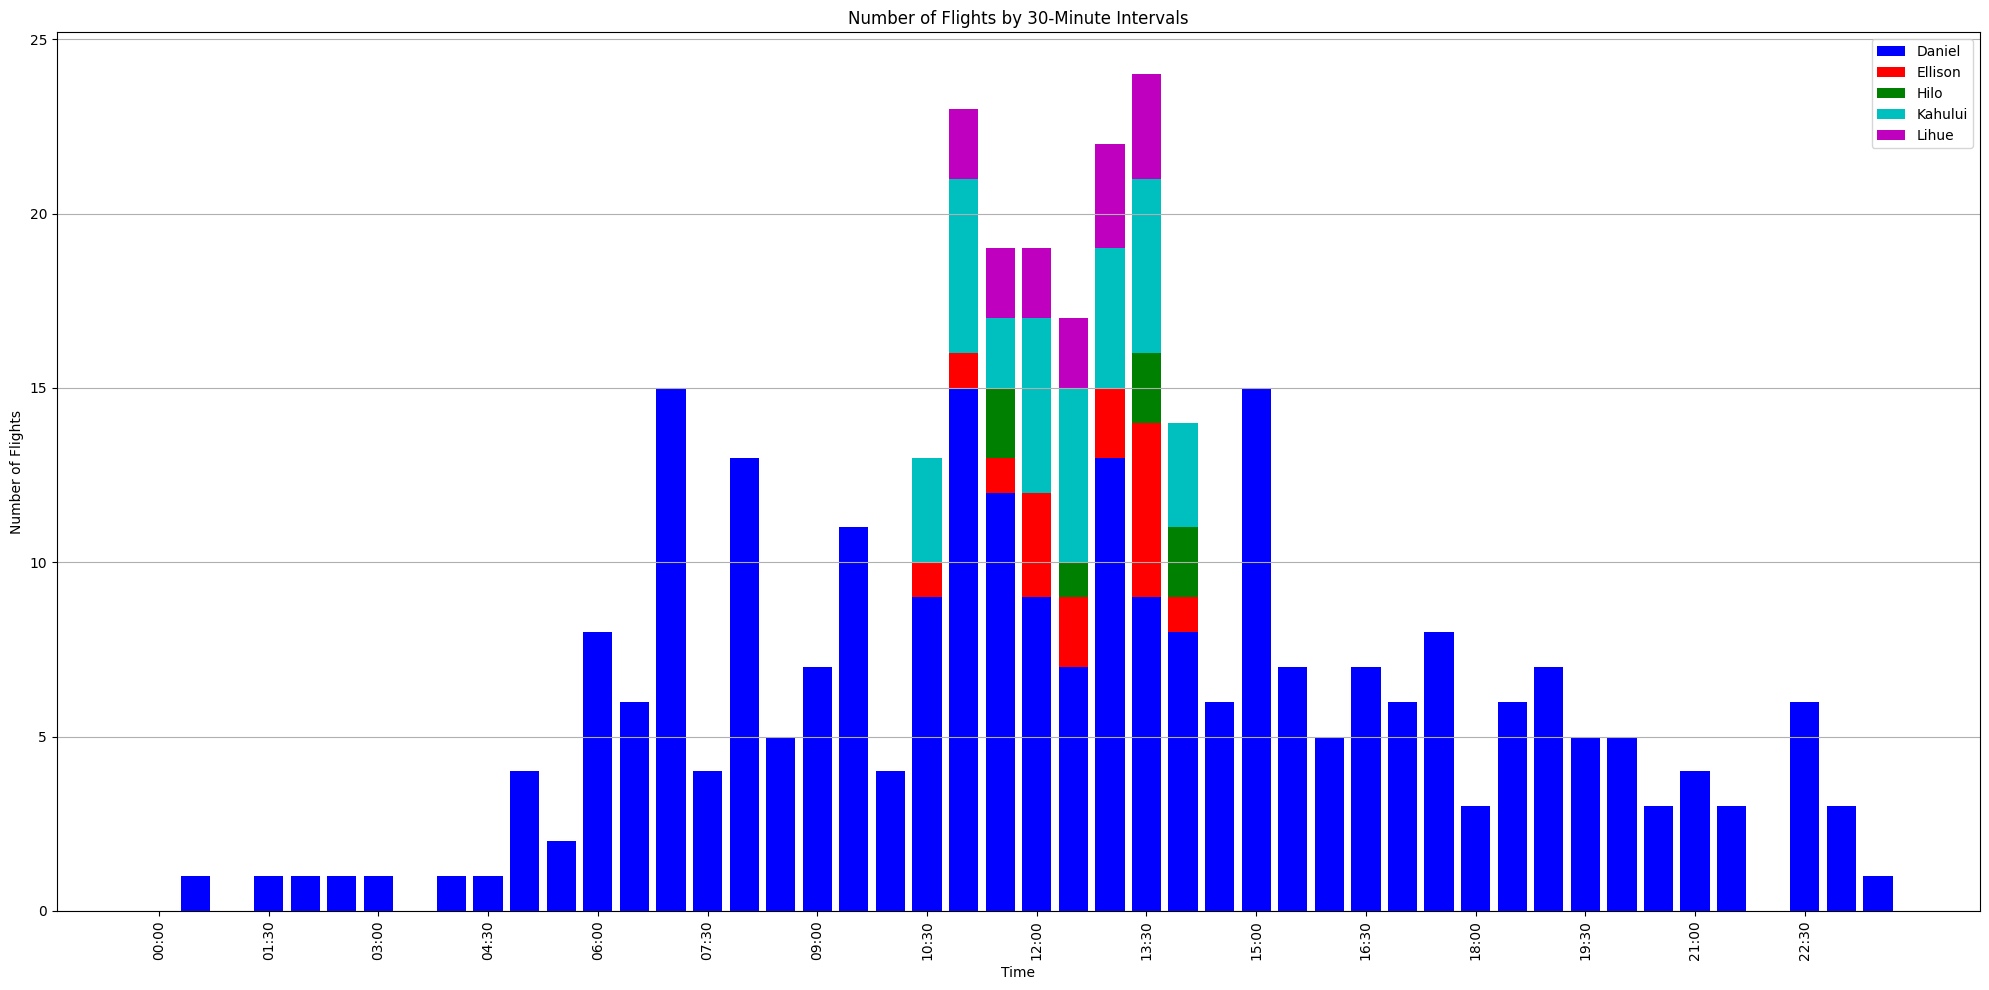

In [21]:

# Load the combined data for plotting
grouped_file_path = output_file
grouped_flights = pd.read_csv(grouped_file_path)

# Ensure 'Interval Time' is treated as a string for plotting
grouped_flights['Interval Time'] = pd.to_datetime(grouped_flights['Interval Time'], format='%H:%M')

# Generate a complete range of intervals for the day
time_range = pd.date_range(start='00:00', end='23:59', freq='30T').strftime('%H:%M')
complete_range = pd.DataFrame(time_range, columns=['Interval Time'])

# Convert 'Interval Time' in both DataFrames to string for merging
grouped_flights['Interval Time'] = grouped_flights['Interval Time'].dt.strftime('%H:%M')

# Merge this complete range with the flight data
merged_flights = complete_range.merge(grouped_flights, on='Interval Time', how='left').fillna(0)

# Convert flight count columns to integer, excluding the 'Interval Time' column
flight_count_columns = merged_flights.columns.difference(['Interval Time'])
merged_flights[flight_count_columns] = merged_flights[flight_count_columns].astype(int)

# Plot the data
plt.figure(figsize=(20, 10))

# Plotting the stacked bar chart
bottom = None
colors = ['b', 'r', 'g', 'c', 'm', 'y', 'k']  # Define colors for each airport

for idx, column in enumerate(flight_count_columns):
    if bottom is None:
        plt.bar(merged_flights['Interval Time'], merged_flights[column], color=colors[idx % len(colors)], label=column)
        bottom = merged_flights[column]
    else:
        plt.bar(merged_flights['Interval Time'], merged_flights[column], bottom=bottom, color=colors[idx % len(colors)], label=column)
        bottom += merged_flights[column]

# Add title and labels
plt.title('Number of Flights by 30-Minute Intervals')
plt.xlabel('Time')
plt.ylabel('Number of Flights')

# Rotate the x-axis labels for better readability
plt.xticks(rotation=90, ticks=range(0, len(merged_flights), 3))

# Add grid for better readability
plt.grid(axis='y')

# Add legend
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()